# 1. Import Libraries

In [1]:
# data management libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# interactive visualizarion libaries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# scikit learn clustering library
from sklearn.cluster import KMeans
# import the silhouette metric
from sklearn.metrics import silhouette_samples, silhouette_score

# 2. Read Data 

In [44]:
df = pd.read_csv('data/transactions.csv')
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
# check for missing values
df.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

# 3. EDA

**Features:** 
- **Step:**  
    Represents the day when the transaction happened. There is a total of 180 steps, so the data runs for six months. This field will be **dropped** since its non significant.
- **Customer:**  
    Represents the unique ID of the person who initialized the transaction. It is formed by the letter `C`, followed by a unique sequence of 10 numbers. There is a total of 4,109 unique customers available in the dataset.
- **Age:**  
    This variable is split into age intervals, starting from 0 to 6, and the letter `U` which stands for Unknown. Age is Unknown only for transactions that have the gender equal to Enterprise. The coding for the numbers is:  
    - `0`: less than 18 years old  
    - `1`: between 19 and 25 years old  
    - `2`: between 26 and 35 years old  
    - `3`: between 36 and 45 years old  
    - `4`: between 46 and 55 years old  
    - `5`: between 56 and 65 years old  
    - `6`: older than 65 years old  
- **Gender:**  
    This variable is coded as `F` for Female, `M` for Male, `E` for Enterprise, and `U` for Unknown. The Unknown group has around 170 customers aged in groups 1, 2, and 3.  
- **Merchant:**  
    Represents the unique ID of the party which receives the transaction. Similar to customer ID, the sequence is formed by the letter `M`, followed by a series of 9 numbers. There is a total of 50 unique merchants in the dataset.  
- **Category:**  
    There are 15 unique categories that label the general type of the transaction:  
    `transportation`, `food`, `health`, `wellness and beauty`, `fashion`, `bars and restaurant`, `hyper`, `sports and toys`, `tech`, `home`, `hotel services`, `other services`, `contents`, `travel`, `leisure`.  
- **Amount:**  
    Represents the value of the transaction. There are only 52 values equal to 0 and no negative values.  
- **Fraud:**  
    A flag column coded with `0` if the transaction was clean and with `1` if the transaction was fraudulent.  
- **zipcodeOri** and **zipMerchant:**  
    These two features were **removed** from the dataset, as they contained a constant value of `28007`, which is a postal code in Ansonville, North Carolina, United States. Therefore, the amount will be from now on expressed in US dollars.  

**Other transformations:**  
- All Unknown for **Age** will be kept. It appears that only Enterprise gender doesn’t have its age, so the missingness is systematic. The `U` will be replaced with number `7`.  
- All Unknown for **Gender** will be erased. It appears that the age for these people is in `1`, `2`, and `3` intervals, which each has an average distribution of `F = 55%`, `M = 44%`, `U = 1%`.

### Preprosessing

In [45]:
# keep the 'fraud' column only for verification purposes as it is not needed for clustering
labels = df['fraud']

# drop the 'fraud' column from the dataframe
df = df.drop(columns=['fraud'])

# drop the columns that are not significant for clustering
df = df.drop(columns=['step', 'customer', 'merchant', 'zipcodeOri', 'zipMerchant'])

#remove 'es_' from the 'category' column
df['category'] = df['category'].str.replace('es_', '', regex=False)

# remove special symbols from all columns
df = df.replace("^.|.$", '', regex=False)

#drop rows that have 'U' in 'gender' column
df = df[df['gender'] != '\'U\'']

# replace 'U' with '7' in age and convert age from str to int
df['age'] = df['age'].replace('\'U\'', '7').str.strip("'\"").astype(int)

# encode the gender column to numeric values
df['gender'] = df['gender'].replace({'\'M\'': 0, '\'F\'': 1, '\'E\'': 2}).infer_objects()

# encode the 'category' column to numeric values
# save the unique categories for later use
categories = df['category'].unique()
# create a mapping dictionary for the categories
category_mapping = {category: idx for idx, category in enumerate(categories)}
# map the categories to their corresponding numeric values
df['category'] = df['category'].map(category_mapping)
# convert the 'category' column to categorical type and then to numeric codes
df.loc[:, 'category'] = df['category'].astype('category').cat.codes

C:\Users\ppapa\AppData\Local\Temp\ipykernel_24736\3710550244.py:23: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [46]:
df.head()

,age,gender,category,amount
0,4,0,0,4.55
1,2,0,0,39.68
2,4,1,0,26.89
3,3,0,0,17.25
4,5,0,0,35.72


### Plotting

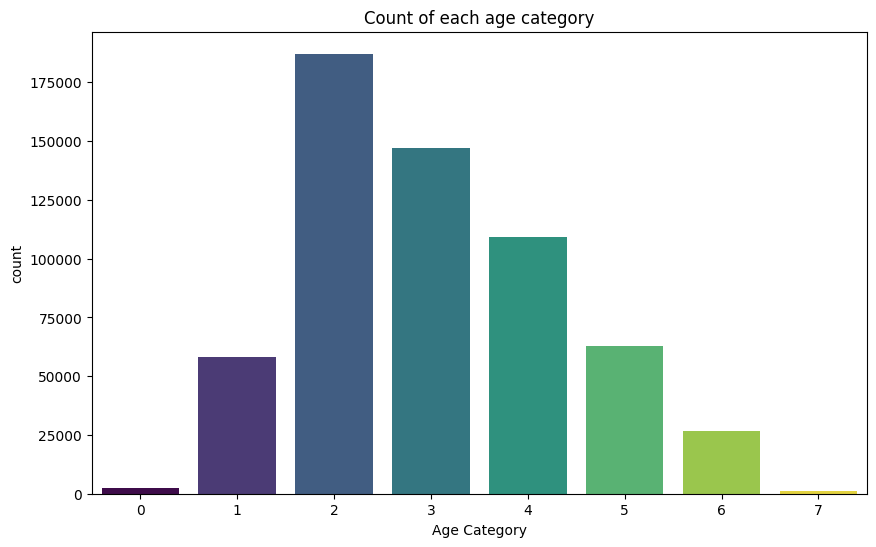

In [57]:
#plot count of each age category
plt.figure(figsize=(10, 6));
sns.countplot(data=df, x='age', hue='age', palette='viridis', legend=False);
plt.title('Count of each age category')
plt.xlabel('Age Category')
plt.show()

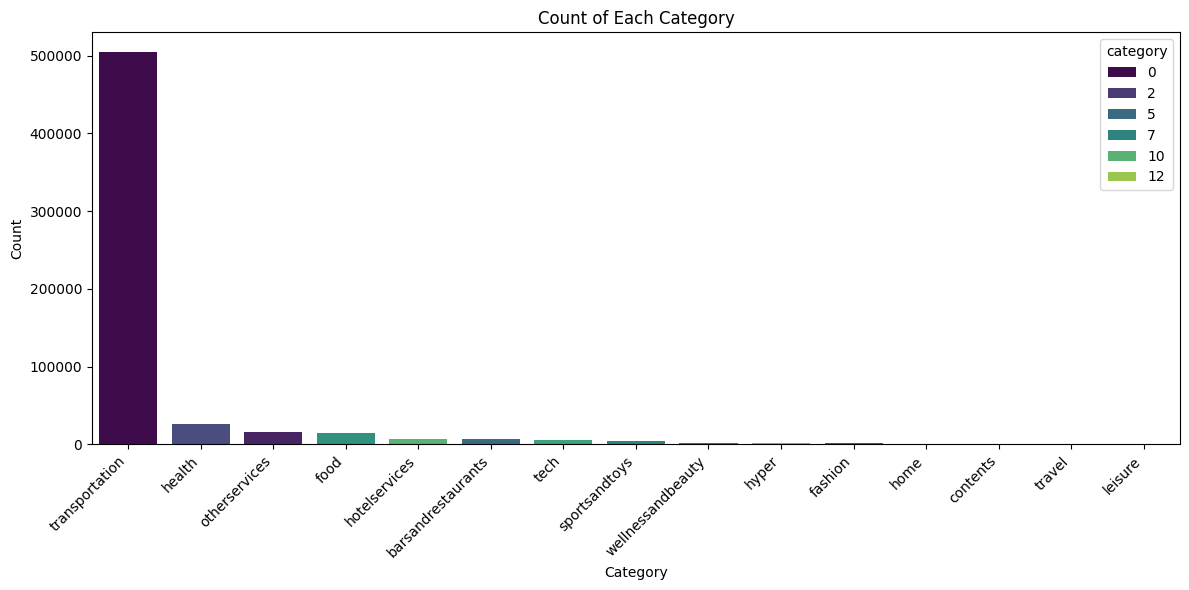

In [52]:
#plot count of each category
plt.figure(figsize=(12, 6))
sns.countplot(data=df, 
    x='category', 
    hue='category', 
    order=df['category'].value_counts().index, 
    palette='viridis', 
    dodge=False)
plt.xticks(ticks=range(len(category_mapping)), labels=[key.strip("'") for key in category_mapping.keys()], rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category')
plt.tight_layout()
plt.show()

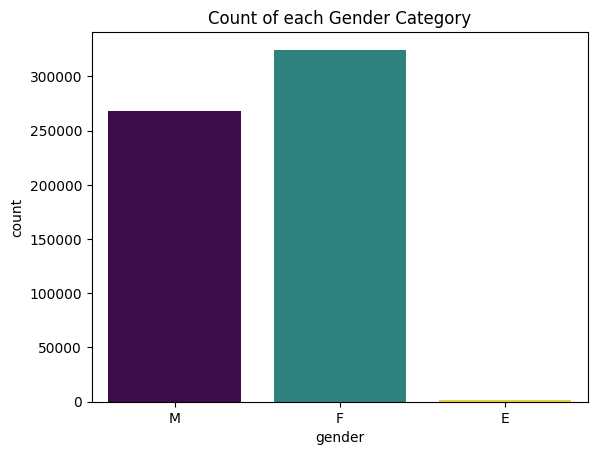

In [58]:
#plot count of each gender
sns.countplot(data=df, x='gender', hue='gender', palette='viridis', legend=False);
plt.title('Count of each Gender Category')
plt.xticks(ticks=[0, 1, 2], labels = ['M', 'F', 'E'])
plt.show()

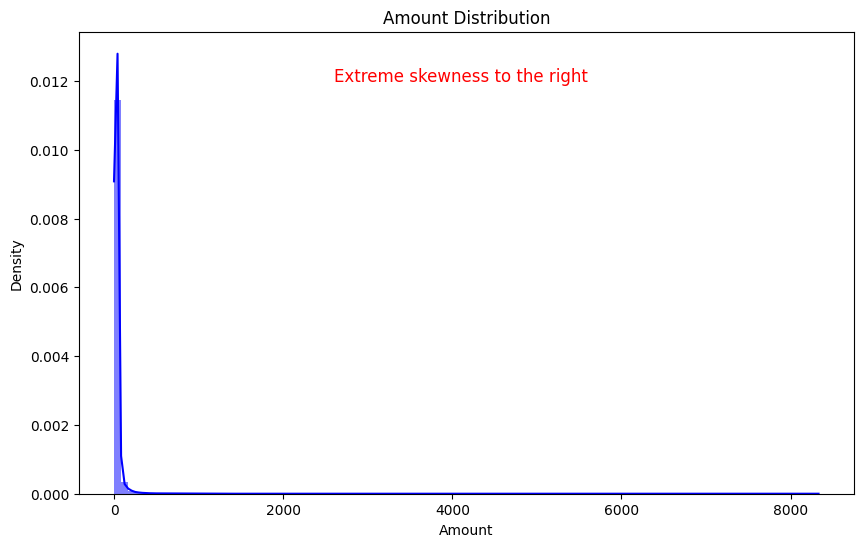

In [72]:
# plot the amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(x=df['amount'], kde=True, color='blue', bins=100, stat='density', linewidth=0, alpha=0.5)
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.text(x=2600, y=0.012, s='Extreme skewness to the right', fontsize=12, color='red')
plt.show()

In [114]:
category_mapping

{"'transportation'": 0,
 "'health'": 1,
 "'otherservices'": 2,
 "'food'": 3,
 "'hotelservices'": 4,
 "'barsandrestaurants'": 5,
 "'tech'": 6,
 "'sportsandtoys'": 7,
 "'wellnessandbeauty'": 8,
 "'hyper'": 9,
 "'fashion'": 10,
 "'home'": 11,
 "'contents'": 12,
 "'travel'": 13,
 "'leisure'": 14}

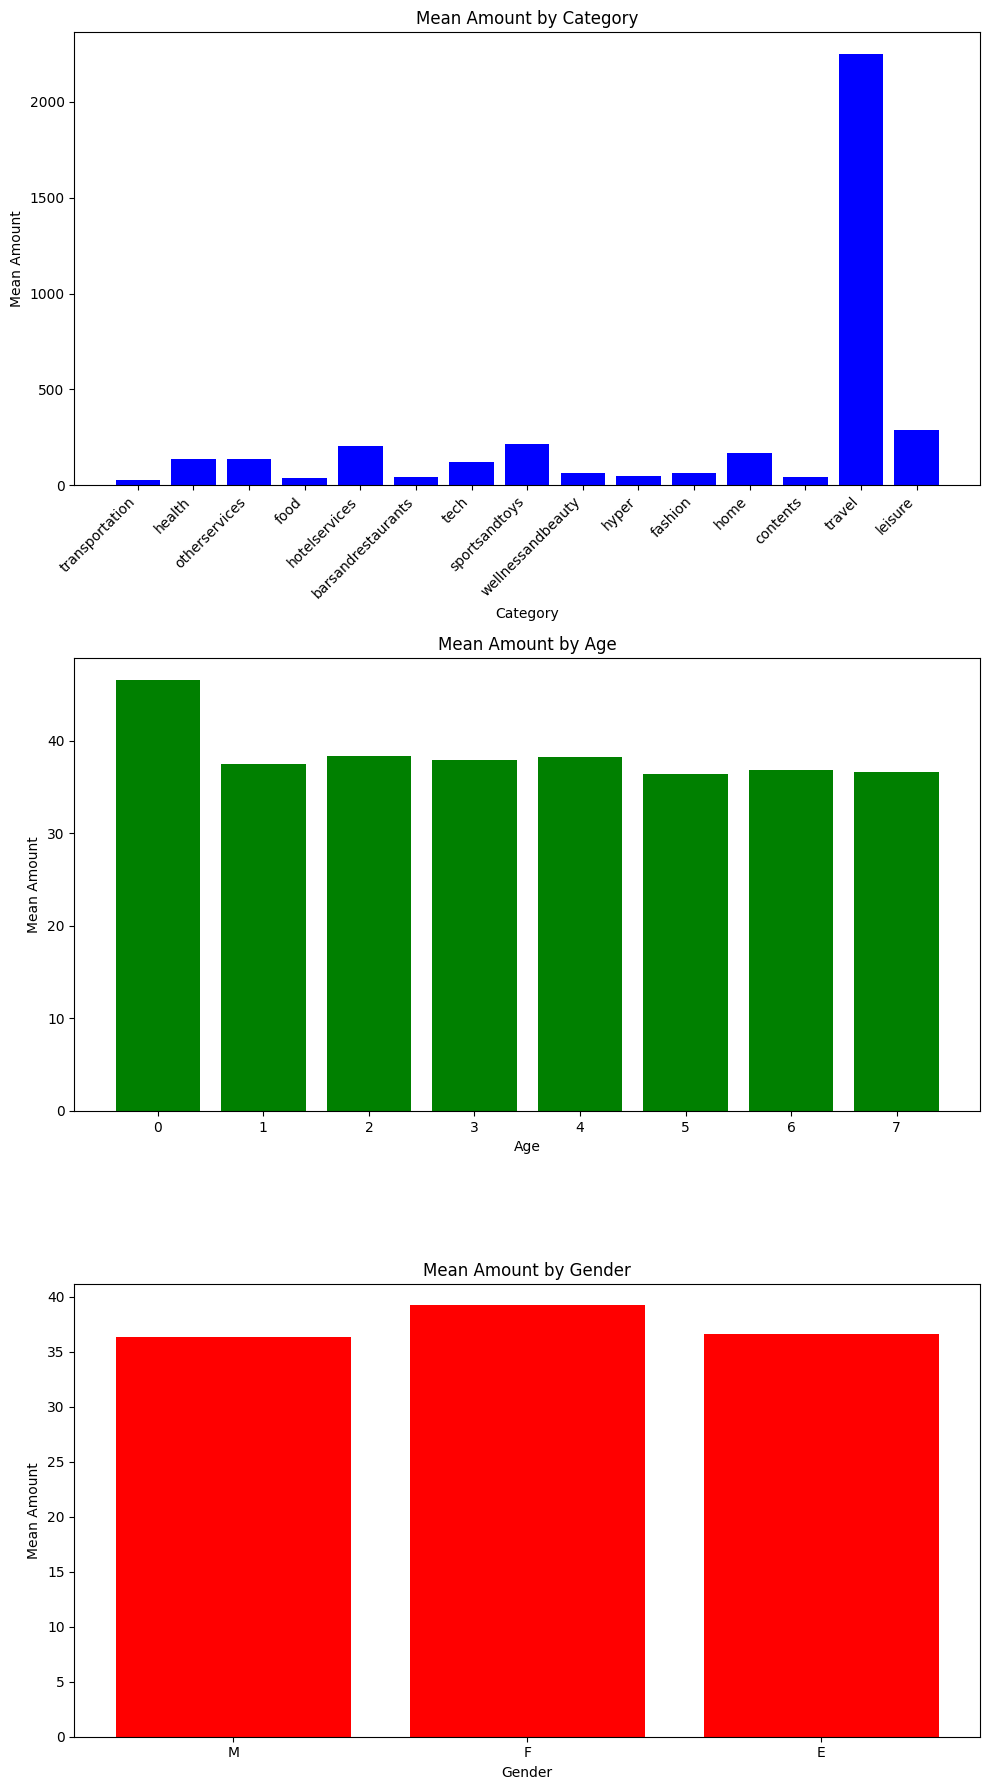

In [ ]:
plt.figure(figsize=(10, 18))
plt.subplot(3, 1, 1)
plt.bar(df.groupby('category')['amount'].describe().index, df.groupby('category')['amount'].describe()['mean'], color='blue')
plt.title('Mean Amount by Category')
plt.xlabel('Category')
plt.xticks(ticks=range(len(category_mapping)), labels=[key.strip("'") for key in category_mapping.keys()], rotation=45, ha='right')
plt.ylabel('Mean Amount') 
plt.subplot(3, 1, 2)
plt.bar(df.groupby('age')['amount'].describe().index, df.groupby('age')['amount'].describe()['mean'], color='green')
plt.title('Mean Amount by Age')
plt.xlabel('Age')
plt.ylabel('Mean Amount')
plt.subplot(3, 1, 3)
plt.bar(df.groupby('gender')['amount'].describe().index, df.groupby('gender')['amount'].describe()['mean'], color='red')
plt.title('Mean Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Amount')
plt.xticks(ticks=[0, 1, 2], labels = ['M', 'F', 'E'])
plt.tight_layout()
plt.show()
